<a href="https://colab.research.google.com/github/darioLabrador/vinho-verde/blob/main/csc2034-ds-demos-master/04_predicting_academic_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Academic Performance
## CSC2034
### Based on Cameron Trotter

Now that we have played around with a few toy examples, let's take a look at tackling a real dataset. In this notebook we will work with the [Academic Performance dataset](https://www.kaggle.com/aljarah/xAPI-Edu-Data) from Kaggle. If after these sessions you want to expand your knowledge in your own time, Kaggle contains wide arrange of datasets and competitions for you to try.

Unlike our synthetic dataset, the Academic Performance dataset contains more than two classes and a wide range of features. We will use this to help you understand the concept of overfitting, cross validation, and how to combat these through ensemble methods.

### Google Colab Setup

All of the notebooks you will be running in these lab sessions are designed to be ran using [Google Colab](https://colab.research.google.com/). For setup instructions, see this repo's README.

In order to make things work on colab, we need to clone this repo and then (in another cell because colab dictates this...) move into the repo directory.

In [218]:
!git clone https://github.com/EllyOK/data_visulisation.git

Cloning into 'data_visulisation'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 44 (delta 11), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (44/44), 42.12 KiB | 634.00 KiB/s, done.
Resolving deltas: 100% (11/11), done.


In [219]:
import os
os.chdir('data_visulisation/csc2034-ds-demos-master')

### Importing Data

First, let's import the Academic Performance dataset. For ease, I have downloaded the dataset and cleaned it up. In data science, cleaning data is an important but time consuming task, and as such I don't expect you to do it here; it would take far too long for the time we have. When working with textual datasets, it is highliy likely it will be provided to you as a CSV file. We can use [pandas](https://pandas.pydata.org/) to create a DataFrame object based on the CSV file we import. Most data science packages will be able to handle DataFrames as input.

In [220]:
import pandas as pd

path = './data/academic_performance_clean.csv'

dataset = pd.read_csv(path, header = 0)

Let's examine the dataset to better understand the format and what it contains.

In [221]:
print(f"Number of examples: {dataset.shape[0]}")
print(f"Number of features: {dataset.shape[1]}")
print(f"List of features:\n\t{dataset.columns}")

print(f"\nExamining the first 5 entries in the dataset:")
display(dataset.head())

Number of examples: 480
Number of features: 16
List of features:
	Index(['Gender', 'Nationality', 'StageID', 'GradeID', 'SectionID', 'Topic',
       'Semester', 'Relation', 'RaisedHands', 'VisitedResources',
       'AnnouncementsView', 'Discussion', 'ParentAnsweringSurvey',
       'ParentSchoolSatisfaction', 'StudentAbsenceDays', 'Class'],
      dtype='object')

Examining the first 5 entries in the dataset:


,Gender,Nationality,StageID,GradeID,SectionID,Topic,Semester,Relation,RaisedHands,VisitedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentSchoolSatisfaction,StudentAbsenceDays,Class
0,Male,Kuwait,LowerLevel,G-04,section_A,IT,First,Father,15,16,2,20,Yes,Good,Under-7,M
1,Male,Kuwait,LowerLevel,G-04,section_A,IT,First,Father,20,20,3,25,Yes,Good,Under-7,M
2,Male,Kuwait,LowerLevel,G-04,section_A,IT,First,Father,10,7,0,30,No,Bad,Above-7,L
3,Male,Kuwait,LowerLevel,G-04,section_A,IT,First,Father,30,25,5,35,No,Bad,Above-7,L
4,Male,Kuwait,LowerLevel,G-04,section_A,IT,First,Father,40,50,12,50,No,Bad,Above-7,M


### Exploratory Data Analysis (EDA)

Before we can begin to train models we need to first perform some EDA. This allows us to better understand the data we have. As we can see fron examining the first few examples in the dataset, some features are numeric whilst some are categorical...

In [222]:
categorical = ['Gender', 'Nationality', 'StageID',
               'GradeID', 'SectionID', 'Topic',
               'Semester', 'Relation', 'ParentAnsweringSurvey',
               'ParentSchoolSatisfaction', 'StudentAbsenceDays']

numerical = ['RaisedHands', 'VisitedResources', 'AnnouncementsView', 'Discussion']

Let's plot some of the categorical features using seaborn to understand the data.

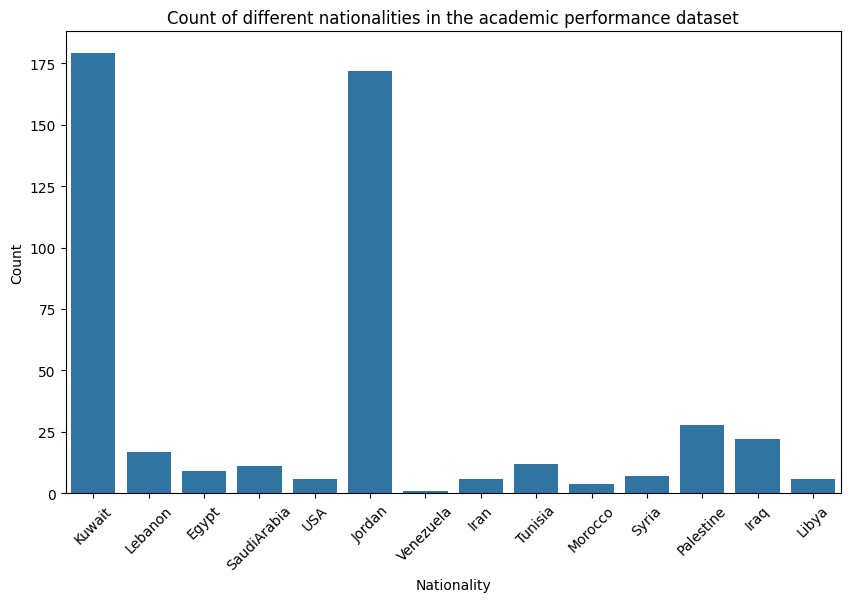

In [223]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 6))
sns.countplot(x = "Nationality", data = dataset)
plt.title("Count of different nationalities in the academic performance dataset")
plt.xlabel("Nationality")
plt.ylabel("Count")
plt.xticks(rotation=45) # Rotate the x labels so they don't overlap
plt.show()
plt.close()

From this plot we can see our dataset is quite imbalanced. Kuwaiti and Jordanian nationals make up a significant proportion of the Nationality examples. As such, we now know we will have to handle this.

Let's now take a look at numerical features. We can output summary statistics for them using `describe()`. The [docs](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) explain the output in detail should you need it.

In [224]:
display(dataset[numerical].describe())

,RaisedHands,VisitedResources,AnnouncementsView,Discussion
count,480.000000,480.000000,480.000000,480.000000
mean,46.775000,54.797917,37.918750,43.283333
std,30.779223,33.080007,26.611244,27.637735
min,0.000000,0.000000,0.000000,1.000000
25%,15.750000,20.000000,14.000000,20.000000
50%,50.000000,65.000000,33.000000,39.000000
75%,75.000000,84.000000,58.000000,70.000000
max,100.000000,99.000000,98.000000,99.000000


Numerical values can also be plotted by examining their distribution.

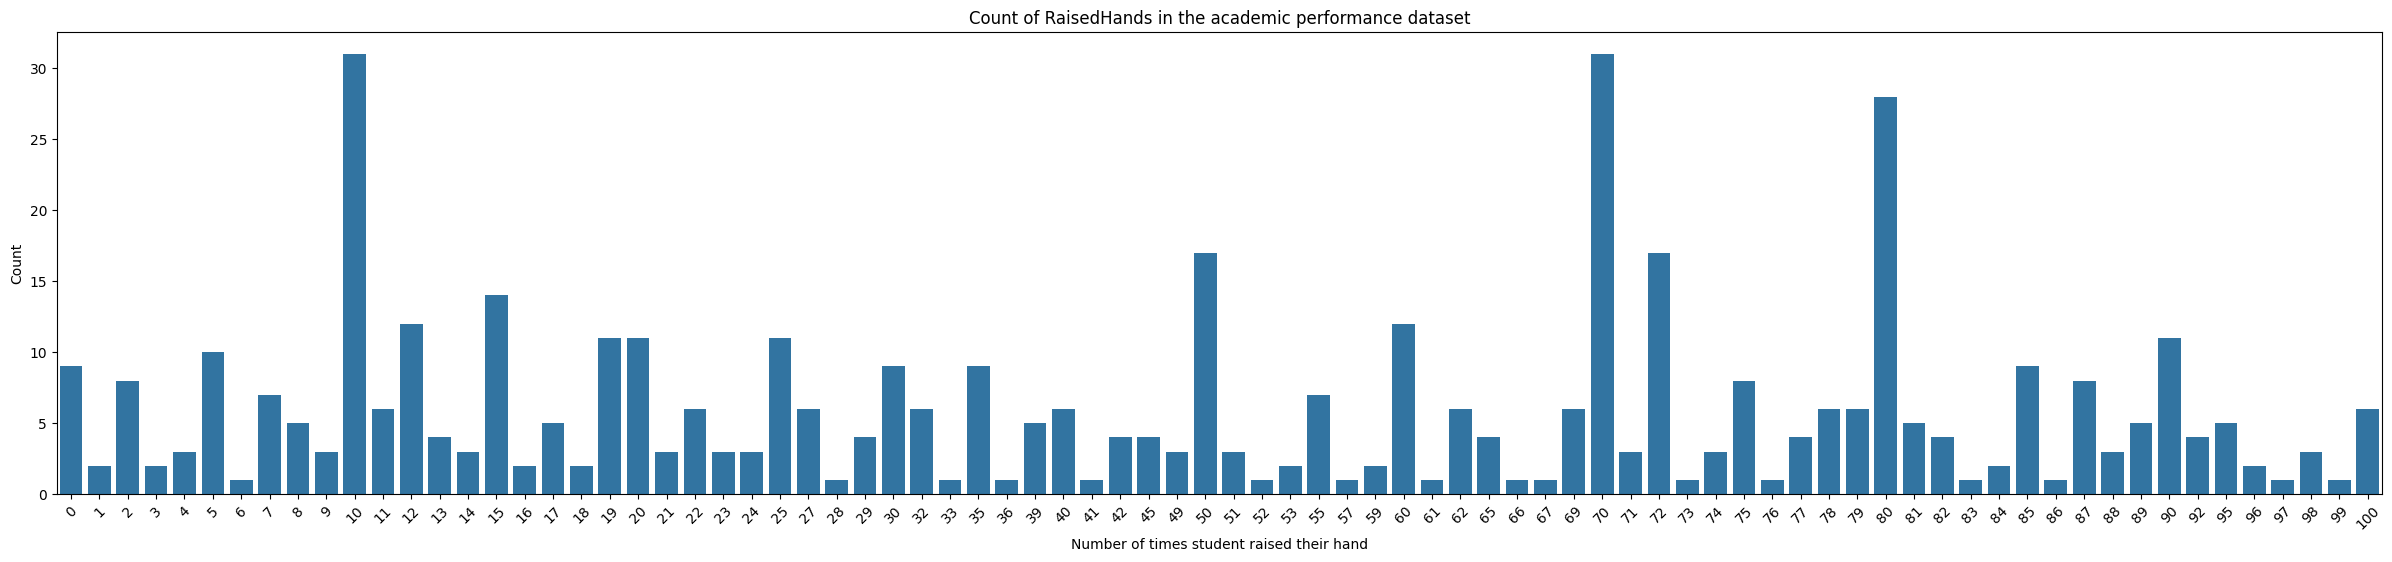

In [225]:
plt.figure(figsize = (30,6))
sns.countplot(x = "RaisedHands", data = dataset)
plt.title("Count of RaisedHands in the academic performance dataset")
plt.xlabel("Number of times student raised their hand")
plt.ylabel("Count")
plt.xticks(rotation=45) # Rotate the x labels so they don't overlap
plt.show()
plt.close()

Using this dataset, we want to predict the `Class` of the student given the other features. In order to do this, we first need to know how many values `Class` can take, as well as its distribution.

Task: Using seaborn, perform some EDA to understand the distribution and possible values `Class` can take.

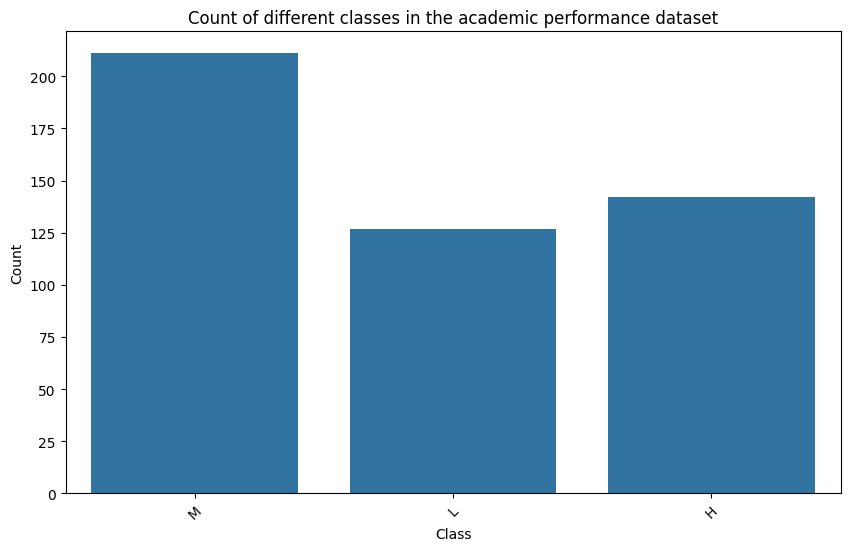

In [226]:
plt.figure(figsize = (10, 6))
sns.countplot(x = "Class",data=dataset)
plt.title("Count of different classes in the academic performance dataset")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45) # Rotate the x labels so they don't overlap
plt.show()
plt.close()

From the plot you have created, we can see there are three possible values `Class` can take; M (Medium), L (Low), or H (High). These tell us how good the student's overall academic performance was.

Now we understand the categorical feature we are going to predict, let's plot a numerical feature, `RaisedHands`, aggregated by *another* categorical feature, `Gender`. This is a very powerful EDA tool to help us fully understand the data we have available. To do this, we create a `FacetGrid` based on `Class` and then fill this with barplots showing `RaisedHands` against `Gender`.

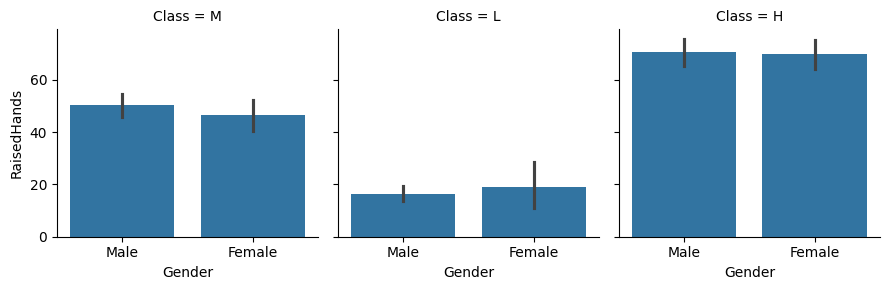

In [227]:
grid = sns.FacetGrid(dataset, col="Class")
grid.map(sns.barplot, "Gender", "RaisedHands", order=["Male", "Female"])

A pretty even `Gender` split for raising hands regardless of `Class`!

Some of seaborn's plots take `kind` arguments which can change how the plotted data is displayed. For example `catplot` can take a wide variety of `kind` arguments, such as `box` or `violin`...

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 26.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 13.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 15.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 8.3% of the points cannot be place

<Figure size 1000x600 with 0 Axes>

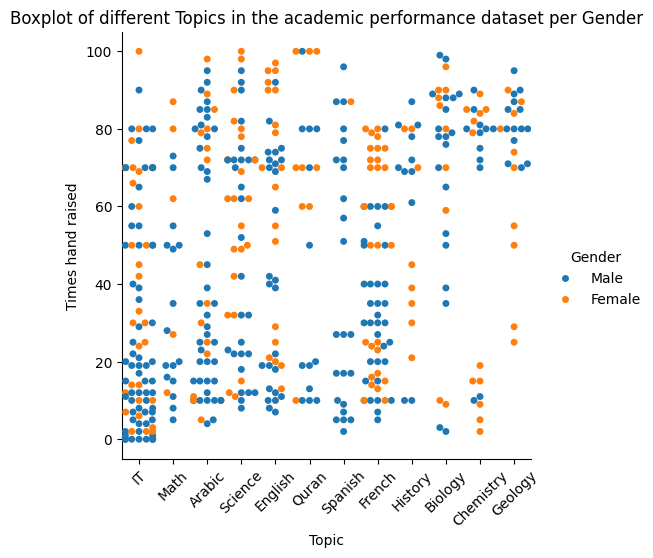

<Figure size 1000x600 with 0 Axes>

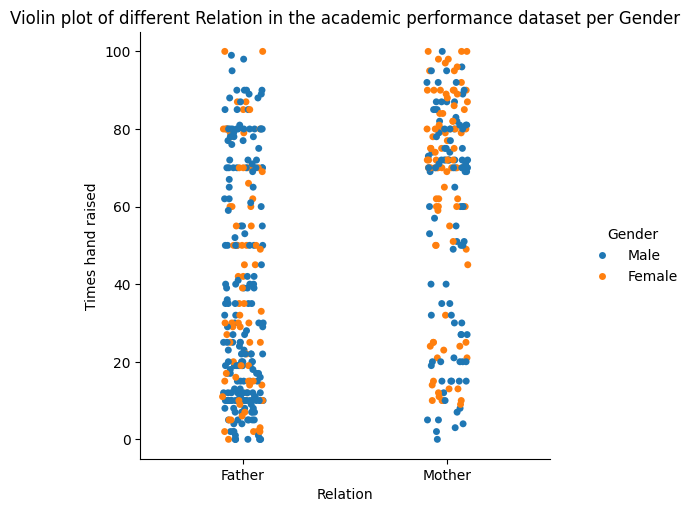

In [228]:
plt.figure(figsize = (10, 6))
sns.catplot(x = "Topic", y = "RaisedHands", data = dataset, kind = "swarm", hue = "Gender")
plt.title("Boxplot of different Topics in the academic performance dataset per Gender")
plt.xlabel("Topic")
plt.ylabel("Times hand raised")
plt.xticks(rotation=45)
plt.show()
plt.close()

plt.figure(figsize = (10, 6))
sns.catplot(x = "Relation", y = "RaisedHands", data = dataset, kind = "strip", hue = "Gender")
plt.title("Violin plot of different Relation in the academic performance dataset per Gender")
plt.xlabel("Relation")
plt.ylabel("Times hand raised")
plt.show()
plt.close()

Task: Before continuing, use the examples above to build a wide variety of plots. Ensure each plot allows you to understand something different about your data.

<Figure size 1000x600 with 0 Axes>

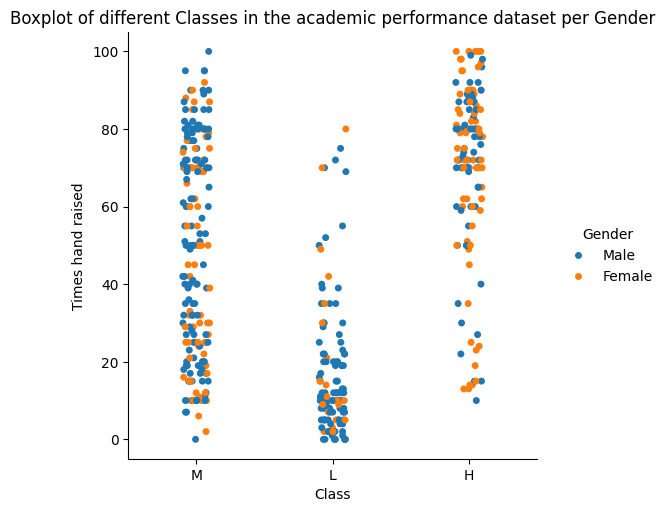

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 6.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Figure size 1000x600 with 0 Axes>

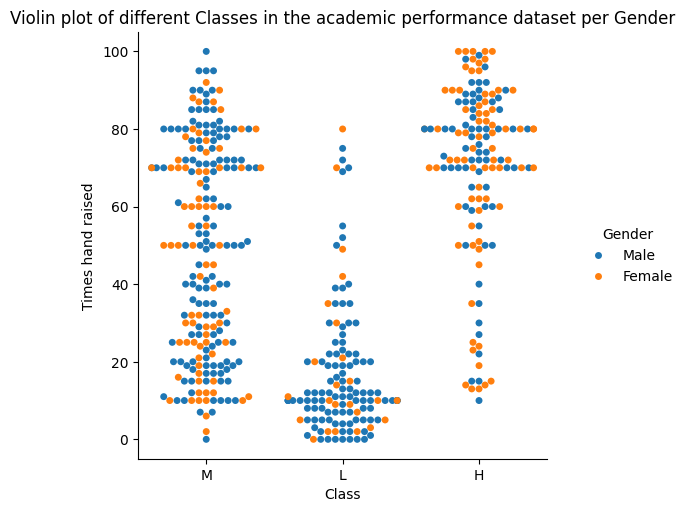

In [229]:
plt.figure(figsize = (10, 6))
sns.catplot(x = "Class", y = "RaisedHands", data = dataset, kind = "strip", hue = "Gender")
plt.title("Boxplot of different Classes in the academic performance dataset per Gender")
plt.xlabel("Class")
plt.ylabel("Times hand raised")
plt.show()
plt.close()

plt.figure(figsize = (10, 6))
sns.catplot(x = "Class", y = "RaisedHands", data = dataset, kind = "swarm", hue = "Gender")
plt.title("Violin plot of different Classes in the academic performance dataset per Gender")
plt.xlabel("Class")
plt.ylabel("Times hand raised")
plt.show()
plt.close()

### One Hot Encoding

When working with categorical data, we sometimes need to convert this to numeric to allow a classifier to train. Sometimes this isn't needed, but in most cases it will be. In reality this is usually a result of a constraint placed by the algorithm implementation rather than the algorithm theory.

One of the easiest ways to convert our categorical features to numeric ones is through the use of One Hot Encoding. This creates *dummy features* for each categorical feature, with a new column created for each possible categorical value. The values in the new dummy feature are binary, denoting whether the categorical feature was of the value of the dummy.

Let's take Gender as an example. This contains 2 possible values; Male or Female. Using One Hot Encoding we will create three new columns in our dataset with the following possible values:

* Male: 0 or 1
* Female: 0 or 1

To add these columns to our dataset, we create the dummy vairables using `get_dummies`, concatinate the columns onto the dataset, and then drop the column we used to create the dummies.


In [230]:
dummies = pd.get_dummies(dataset["Gender"])
dataset_onehot = pd.concat((dataset, dummies), axis = 1) # axis = 1 == columns (0 == rows)
dataset_onehot = dataset_onehot.drop("Gender", axis = 1)

Let's now examine the shape of our dataset like we did at the beginning.

In [231]:
print(f"Number of examples: {dataset_onehot.shape[0]}")
print(f"Number of features: {dataset_onehot.shape[1]}")
print(f"List of features:\n\t{dataset_onehot.columns}")

print(f"\nExamining the first 5 entries in the dataset:")
display(dataset_onehot.head())

Number of examples: 480
Number of features: 17
List of features:
	Index(['Nationality', 'StageID', 'GradeID', 'SectionID', 'Topic', 'Semester',
       'Relation', 'RaisedHands', 'VisitedResources', 'AnnouncementsView',
       'Discussion', 'ParentAnsweringSurvey', 'ParentSchoolSatisfaction',
       'StudentAbsenceDays', 'Class', 'Female', 'Male'],
      dtype='object')

Examining the first 5 entries in the dataset:


,Nationality,StageID,GradeID,SectionID,Topic,Semester,Relation,RaisedHands,VisitedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentSchoolSatisfaction,StudentAbsenceDays,Class,Female,Male
0,Kuwait,LowerLevel,G-04,section_A,IT,First,Father,15,16,2,20,Yes,Good,Under-7,M,False,True
1,Kuwait,LowerLevel,G-04,section_A,IT,First,Father,20,20,3,25,Yes,Good,Under-7,M,False,True
2,Kuwait,LowerLevel,G-04,section_A,IT,First,Father,10,7,0,30,No,Bad,Above-7,L,False,True
3,Kuwait,LowerLevel,G-04,section_A,IT,First,Father,30,25,5,35,No,Bad,Above-7,L,False,True
4,Kuwait,LowerLevel,G-04,section_A,IT,First,Father,40,50,12,50,No,Bad,Above-7,M,False,True


Now we have 17 columns instead of 16, as we have added 2 and removed 1.

Task: Create dummy featues for all other categorical features in the dataset, except `Class`. You may find the use of an iterator useful here. Note that above, we created a new copy of the dataset called `dataset_onehot`.

In [232]:
remaining_categorical = ['Nationality', 'StageID',
               'GradeID', 'SectionID', 'Topic',
               'Semester', 'Relation', 'ParentAnsweringSurvey',
               'ParentSchoolSatisfaction', 'StudentAbsenceDays']

for feature in remaining_categorical:
    dummies = pd.get_dummies(dataset_onehot[feature])
    dataset_onehot = pd.concat((dataset_onehot, dummies), axis = 1)
    dataset_onehot = dataset_onehot.drop(feature, axis = 1)

Run the below checks. If any return False, take another look at the code you have written before continuing.

In [233]:
print(f"Number of features check: {dataset_onehot.shape[1] == 59}")

Number of features check: True


### Handling our Predictive Feature

As the feature we will be predicting, `Class`, is categorical we need to do something different when converting it to numeric. This is because our models will only predict one column as output. If we One Hot Encoded `Class` it would then be split over three columns, making it impossible to use as a label.

To get around this we can set numeric lables for the different classes and iterate through the dataset converting as we go. Once converted, we drop `Class` from the One Hot Encoded dataset and replace it with the `Class` column we just created.

In [234]:
class_numeric = {'L': 0, 'M': 1, 'H': 2}

numeric_class_dataset = dataset.replace({'Class': class_numeric})

dataset_onehot = dataset_onehot.drop('Class', axis = 1)
dataset_onehot = pd.concat((dataset_onehot, numeric_class_dataset['Class']), axis = 1)

<ipython-input-234-b347664137e6>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  numeric_class_dataset = dataset.replace({'Class': class_numeric})


Let's look at the dataset we have now...

In [235]:
print(f"Number of examples: {dataset_onehot.shape[0]}")
print(f"Number of features: {dataset_onehot.shape[1]}")
print(f"List of features:\n\t{dataset_onehot.columns}")

print(f"\nExamining the first 5 entries in the dataset:")
display(dataset_onehot.head())

Number of examples: 480
Number of features: 59
List of features:
	Index(['RaisedHands', 'VisitedResources', 'AnnouncementsView', 'Discussion',
       'Female', 'Male', 'Egypt', 'Iran', 'Iraq', 'Jordan', 'Kuwait',
       'Lebanon', 'Libya', 'Morocco', 'Palestine', 'SaudiArabia', 'Syria',
       'Tunisia', 'USA', 'Venezuela', 'HighSchool', 'LowerLevel',
       'MiddleSchool', 'G-02', 'G-04', 'G-05', 'G-06', 'G-07', 'G-08', 'G-09',
       'G-10', 'G-11', 'G-12', 'section_A', 'section_B', 'section_C', 'Arabic',
       'Biology', 'Chemistry', 'English', 'French', 'Geology', 'History', 'IT',
       'Math', 'Quran', 'Science', 'Spanish', 'First', 'Second', 'Father',
       'Mother', 'No', 'Yes', 'Bad', 'Good', 'Above-7', 'Under-7', 'Class'],
      dtype='object')

Examining the first 5 entries in the dataset:


,RaisedHands,VisitedResources,AnnouncementsView,Discussion,Female,Male,Egypt,Iran,Iraq,Jordan,...,Second,Father,Mother,No,Yes,Bad,Good,Above-7,Under-7,Class
0,15,16,2,20,False,True,False,False,False,False,...,False,True,False,False,True,False,True,False,True,1
1,20,20,3,25,False,True,False,False,False,False,...,False,True,False,False,True,False,True,False,True,1
2,10,7,0,30,False,True,False,False,False,False,...,False,True,False,True,False,True,False,True,False,0
3,30,25,5,35,False,True,False,False,False,False,...,False,True,False,True,False,True,False,True,False,0
4,40,50,12,50,False,True,False,False,False,False,...,False,True,False,True,False,True,False,True,False,1


### Splitting the dataset

Before we go any further, let's ensure we have a train and test set. Before doing this, we need to drop `Class` from the dataset and assign it as our label class.

Task: Split your dataset so that 33% of the data is in the test set. Ensure `random_state` is set to 10.

In [236]:
from sklearn.model_selection import train_test_split

data = dataset_onehot.drop(['Class'], axis = 1).values
labels = dataset['Class'].values

data_train, data_test, labels_train, labels_test = train_test_split(data,
                                                                    labels,
                                                                    test_size = 0.33,
                                                                    random_state = 10)

print(data_train.shape)

(321, 58)


### Oversampling the Dataset

Now we have our dataset in a form useable to train a model on. Now, we need to make sure our dataset is balanced. Based on our EDA previously, we know that `Class` value Medium, now 1, is about twice as prevelant in the dataset as Low (0) or High (2). We can use SMOTE to oversample our train set to fix this.

Task: Using what you saw in the previous notebook, use SMOTE to oversample our train set, balancing the number of classes. Set `random_state` equal to 10 to ensure reproducability.

In [237]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=10)

data_train, labels_train = smote.fit_resample(data_train, labels_train)

Run the below checks. If any return False, take another look at the code you have written before continuing.

In [238]:
import numpy as np
unique, counts = np.unique(labels_train, return_counts=True)

print(f"After SMOTE, number of class examples equal? {all(counts == 135)}")

After SMOTE, number of class examples equal? True


### Splitting and Scaling the Data

Now that we have a balanced dataset, we need to split it into a training and test set and then scale both sets based on the train set's values.

Task: Scale your dataset based on the training set. Again, ensure your `random_state` is set to 10.

In [248]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split
data_train, data_test, labels_train, labels_test = train_test_split(data,
                                                                    labels,
                                                                    test_size = 0.33,
                                                                    random_state = 10)

scaler = StandardScaler()

# Scale
data_train_scaled = scaler.fit_transform(data_train)
data_test_scaled = scaler.transform(data_test)

Run the below checks. If any return False, take another look at the code you have written before continuing.

In [249]:
print(f"Size of training set check: {data_train_scaled.shape == (405, 58)}")
print(f"Size of test set check: {data_test_scaled.shape == (159, 58)}")

Size of training set check: False
Size of test set check: True


### Training a Model

Now we have a dataset ready to train a model, let's look at doing that! Let's start by looking at a non-linear SVM.

Task: Using the previous notebooks to help you, create a non-linear SVM using the following hyperparameters. Train the model, and generate a test set accuracy score.

In [253]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

C = 100
kernel = 'poly'
random_state = 10
degree = 10
coef0 = 9

non_linear_svm= SVC(kernel = kernel,
          degree = degree,
          C = C,
          coef0 = coef0, random_state=random_state)

non_linear_svm.fit(data_train_scaled, labels_train)

non_linear_svm_predictions = non_linear_svm.predict(data_test_scaled)

test_acc = accuracy_score(labels_test, non_linear_svm_predictions)

print(f"Test acc: {test_acc * 100}%")

Test acc: 75.47169811320755%


Let's take a look at the accuracy we achieve.

In [254]:
print(f"Test acc: {test_acc * 100}%")

Test acc: 75.47169811320755%


Run the below checks. If any return False, take another look at the code you have written before continuing.

In [255]:
print(f"Test set accuracy check: {test_acc * 100 == 75.47169811320755}")

Test set accuracy check: True


### Preventing Overfitting

One big problem faced by data science models is that of overfitting. This occurs when the trained model has been unable to generalise well with the training data we have provided it. If this happens, our model will perform very well on the training set, but perform worse on the test set. You will go into this in more detail in your lectures.

Let's check our SVM for overfitting. We can do this by predicting on the train set, generating an accuracy score, and comparing it to the test set accuracy.

In [256]:
non_linear_svm_predictions = non_linear_svm.predict(data_train_scaled)
train_acc = accuracy_score(labels_train, non_linear_svm_predictions)

print(f"Train acc: {train_acc * 100}%")
print(f"Test acc: {test_acc * 100}%")

Train acc: 100.0%
Test acc: 75.47169811320755%


Based on these results, we are almost certainly overfitting. We can tell this because of the 100% training accuracy, but only 75% accuracy on the test set. This is likely our hyperparameters.

#### Hyperparameter Tuning and Cross Validation

In a previous notebook, I mentioned how hyparameters are values you need to set to allow your model to train. The values you set for these hyperparameters can greatly influence how well your model can generalise, preventing overfitting. But how do you know which hyperparameters to choose?

To help us decide which hyperparameters to pass to our models, we can utilise a process known as hyperparameter tuning. The simplest form of this is known as a Grid Search. During a Grid Search, we provide a list of values to try out for each hyperparameter. In practise a subset of hyperparameters are used, especially for deep learning models - in my research a grid search on a deep learning model took just over 1 month to finish using 2 GPUs!

When we perform hyperparameter tuning, we don't want to expose our model to the test set as this may impact generalisation and stops us being able to produce a final evaluation on unseen data. With large datasets, often the train set will be split further into an evaluation set to get around this. The train set will be used for training, hyperparameter searches will be evaluated against the evaluation set, and the test set will be reserved for final evaluation on unseen data.

In our case however we have a small dataset. To allow us to still perform hyperparameter tuning we can utilise a concept known as Cross Validation. Again you will go into more detail in your lectures, but cross validation allows you to split your training set multiple times into N *folds*. Hyperparameter tuning is then performed on the combination of these folds. This gives us, in essence, both a training and validation set even though we have very little data to work with.

Let's try some hyperparameter tuning using cross validation on our non-linear SVM and see if we can reduce our overfitting. Somewhat annoyingly, we now have a hyperparameter for our cross validation - the number of folds!

Note this next code block might take a little while to run...

In [257]:
from sklearn.model_selection import GridSearchCV

number_of_folds = 5
random_state = 10

parameters_to_tune = [{'kernel': ['poly', 'rbf'],
                      'C': [1, 10],
                      'degree': [1, 40],
                      'coef0': [1, 9]}]

search = GridSearchCV(SVC(random_state = random_state), parameters_to_tune, cv = number_of_folds)
search.fit(data_train_scaled, labels_train)

print(f"Best parameters set found: {search.best_params_}")

Best parameters set found: {'C': 10, 'coef0': 1, 'degree': 1, 'kernel': 'rbf'}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py", line 276, in fit
    raise ValueError(
ValueError: The du

We have found a set of hyperparameters that the search believes will reduce overfitting and improve our test set accuracy the most! Let's train a model using the found parameters and check.

In [258]:
non_linear_svm = SVC(kernel = search.best_params_['kernel'],
                     degree = search.best_params_['degree'],
                     C = search.best_params_['C'],
                     coef0 = search.best_params_['coef0'], random_state = 10)
non_linear_svm.fit(data_train_scaled, labels_train)

non_linear_svm_predictions = non_linear_svm.predict(data_train_scaled)
train_acc = accuracy_score(labels_train, non_linear_svm_predictions)

non_linear_svm_predictions = non_linear_svm.predict(data_test_scaled)
test_acc = accuracy_score(labels_test, non_linear_svm_predictions)

print(f"Train acc: {train_acc * 100}%")
print(f"Test acc: {test_acc * 100}%")

Train acc: 98.75389408099689%
Test acc: 77.35849056603774%


Now our training accuracy has dropped to 87% but our test accuracy has increased to nearl 79%. This indicates the hyperparameters found in the search have had the desired effect - our overfitting has been reduced! With a larger parameter search, we may be able to increase our test set acciracy even further.

### Decision Trees and Random Forests

Now let's take a look at training a decision tree on the data we have.

Task: Using the transformed data, train a decision tree, and generate a train and test accuracy to allow for an overfitting check.

In [ ]:
random_state = 10

decision_tree = #...

decision_tree_predictions = #...
train_acc = #...

decision_tree_predictions = #...
test_acc = #...

print(f"Train acc: {train_acc * 100}%")
print(f"Test acc: {test_acc * 100}%")

Run the below checks. If any return False, take another look at the code you have written before continuing.

In [ ]:
print(f"Train set accuracy check: {train_acc * 100 == 100.0}")
print(f"Test set accuracy check: {test_acc * 100 == 71.0691823899371}")

One again, we observe overfitting. In fact, decisions trees are so prone to overfitting it is rare to see them used on their own. One way to reduce their overfitting is to train multiple differnt decisions trees and then use these to vote on the final result. This is known as a random forest, as your model consists of an ensamble of randomly generated decision trees. Let's take a look at building one of these.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=50, max_depth=50, random_state=10)
random_forest.fit(data_train_scaled, labels_train)

random_forest_predictions = random_forest.predict(data_train_scaled)
train_acc = accuracy_score(labels_train, random_forest_predictions)

random_forest_predictions = random_forest.predict(data_test_scaled)
test_acc = accuracy_score(labels_test, random_forest_predictions)

print(f"Train acc: {train_acc * 100}%")
print(f"Test acc: {test_acc * 100}%")

We see better test accuracy here, but the model may still be overfitting. Let's look at performing a hyperparameter search and seeing if we can do better.

Task: Using GridSearchCV, perform a 5-fold cross-validation on the Random Forest. Using the best parameters found, train another Random Forest and generate train and test set accuracies.

In [ ]:
random_state = 10
number_of_folds = 5

parameters_to_tune = [{'n_estimators': [10, 15],
                      'max_depth': [5, 10]}]

search = GridSearchCV(RandomForestClassifier(random_state = random_state), parameters_to_tune, cv = number_of_folds)
search.fit(data_train_scaled, labels_train)

print(f"Best parameters set found: {search.best_params_}")

random_forest = RandomForestClassifier(n_estimators=search.best_params_['n_estimators'],
                                       max_depth=search.best_params_['max_depth'],
                                       random_state=10)
random_forest.fit(data_train_scaled, labels_train)

random_forest_predictions = random_forest.predict(data_train_scaled)
train_acc = accuracy_score(labels_train, random_forest_predictions)

random_forest_predictions = random_forest.predict(data_test_scaled)
test_acc = accuracy_score(labels_test, random_forest_predictions)

print(f"Train acc: {train_acc * 100}%")
print(f"Test acc: {test_acc * 100}%")


Run the below checks. If any return False, take another look at the code you have written before continuing.

In [ ]:
print(f"Train set accuracy check: {train_acc * 100 == 89.38271604938272}")
print(f"Test set accuracy check: {test_acc * 100 == 74.84276729559748}")

After tuning, we can see our train and test set accuracies are now close together. Even though we observe a drop in training accuracy, our test accuracy has very slightly increased - suggesting we have prevented overfitting and produced a generalised model. Again, with a larger hyperparameter search we may be able to do better here.